# The phase unwrapping of under-sampled interferograms using compact radial basis function neural networks (serial version)

MIT License

Copyright (c) 

Pierre-Alexandre Gourdain<br>
Department of Physics and Astronomy<br>
University of Rochester<br>
Rochester, NY 14627<br>
USA
 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

If you find this software useful and used it inside a publication, use the reference below in your bibliography:<br>
https://arxiv.org/abs/2210.10541

This work was supported by the NSF under the grant number PHY-1943939.

In [1]:
import numpy as np
import math
from math import sin, cos, sqrt
from numpy.linalg import norm, solve
from scipy import interpolate
import time
from IPython.display import clear_output
from numba import jit

In [2]:
#to display inside the notebook!
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='nipy_spectral')
%matplotlib inline
import matplotlib.font_manager
from matplotlib.ticker import StrMethodFormatter
plt.rcParams['font.sans-serif'] = "Latin Modern Roman"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['mathtext.fontset'] = "stix"
# if fonts are missing install the latin family in the font directory (use function below to find the system directory)
# print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='otf'))
# rebuild the cache list for matplotlib and restart the kernel
# matplotlib.font_manager._rebuild()

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def plot_2D(phi,box,name,title='',interpolate=True,fname='',cmap=plt.cm.nipy_spectral):
    asp=len(phi[0,:])/len(phi[:,0])
    fig, ax = plt.subplots(figsize=(15,15*asp))

    im = plt.imshow(np.flip(np.transpose(phi),axis=0), cmap=cmap, vmin=phi.min(), vmax=phi.max(),extent=box)
    if (interpolate):
        im.set_interpolation('bicubic')

    cb = fig.colorbar(im,shrink=.75)
    plt.xlabel('x', rotation=0)
    plt.ylabel('y', rotation=90)
    cb.ax.set_ylabel(name, rotation=-90)
    cb.ax.yaxis.set_label_coords(4.5, 0.5)
    plt.title(title)
    if (len(fname)>0):
        plt.savefig(fname,bbox_inches='tight')
#     plt.tight_layout()
    plt.show()


In [4]:
#compiled functions with no check on r (i.e. 0<r<1)
@jit(nopython=True)
def rbf(r): 
    # 1->psi_{3,2} Wendland
    return 1 + r**2*(-9.333333333333334 + r**2*(70 + r*(-149.33333333333334 + r*(140 + r*(-64 + (35*r)/3.)))))
@jit(nopython=True)
def drbf(r):
    # 1->psi_{3,2} Wendland
    return r*(-18.666666666666668 + r**2*(280 + r*(-746.6666666666666 + r*(840 + r*(-448 + (280*r)/3.)))))
@jit(nopython=True)
def d2rbf(r):
    # 1->psi_{3,2} Wendland
    return -18.666666666666668 + r**2*(840 + r*(-2986.6666666666665 + r*(4200 + r*(-2688 + (1960*r)/3.))))

In [5]:
@jit(nopython=True)
def W(x):
    while (x>np.pi):
        x-=2.*np.pi
    while (x<=-np.pi):
        x+=2.*np.pi
    return x

In [6]:
@jit(nopython=True)
def WF(x):
    for i in range (len(x)):
        x[i]=W(x[i])
    return x

In [7]:
@jit(nopython=True)
def WF2D(x):
    y=np.copy(x)
    for i in range (len(x[:,0])):
        for j in range (len(x[0,:])):
            y[i,j]=W(x[i,j])
    return y

In [8]:
@jit(nopython=True)
def DTR(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(0,n-1):
        y[i]=x[i+1]-x[i]
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y   

In [9]:
@jit(nopython=True)
def DTL(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n):
        y[i]=x[i]-x[i-1]
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    return y   

In [10]:
@jit(nopython=True)
def DTC(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n-1):
        y[i]=(x[i+1]-x[i-1])*.5
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y  

In [11]:
@jit(nopython=True)
def D2T(x):
    n=len(x)
    y=np.zeros(n)
    for i in range(1,n-1):
        y[i]=(x[i+1]-2*x[i]+x[i-1])
    y[0]=y[2]+(y[1]-y[2])/((1)-(2))*((0)-(2))
    y[n-1]=y[n-3]+(y[n-2]-y[n-3])/((n-2)-(n-3))*((n-1)-(n-3))
    return y   

In [12]:
#constants
N_EQ=12
N_DOF=5
tiny=1e-15

In [13]:
def unpack_data(phi,mask):
    ni=len(phi[:,0])
    nj=len(phi[0,:])
    Nt=0
    for j in range (nj):
        for i in range (ni):
            if (mask[i,j]==1):
                Nt+=1
    data=np.zeros(Nt*N_EQ)
    grid=np.zeros(Nt*2)
    k=0
    d_phi_dx_R=np.zeros((ni,nj))
    d_phi_dx_L=np.zeros((ni,nj))
    d2_phi_dx2=np.zeros((ni,nj))
    for j in range (nj):
        d_phi_dx_R[:,j]=DTR(phi[:,j])
        d_phi_dx_L[:,j]=DTL(phi[:,j])
        d2_phi_dx2[:,j]=WF(D2T(phi[:,j]))
    d_phi_dy_R=np.zeros((ni,nj))
    d_phi_dy_L=np.zeros((ni,nj))
    d2_phi_dy2=np.zeros((ni,nj))
    for i in range (ni):
        d_phi_dy_R[i,:]=DTR(phi[i,:])
        d_phi_dy_L[i,:]=DTL(phi[i,:])
        d2_phi_dy2[i,:]=WF(D2T(phi[i,:]))
    for j in range (nj):
        for i in range (ni):
            if (mask[i,j]==1):
                grid[k*2+0]=i
                grid[k*2+1]=j
                data[k*N_EQ+0]=cos(phi[i,j])
                data[k*N_EQ+1]=sin(phi[i,j])
                data[k*N_EQ+2]=cos(d_phi_dx_L[i,j])
                data[k*N_EQ+3]=sin(d_phi_dx_L[i,j])
                data[k*N_EQ+4]=cos(d_phi_dy_L[i,j])
                data[k*N_EQ+5]=sin(d_phi_dy_L[i,j])
                data[k*N_EQ+6]=cos(d_phi_dx_R[i,j])
                data[k*N_EQ+7]=sin(d_phi_dx_R[i,j])
                data[k*N_EQ+8]=cos(d_phi_dy_R[i,j])
                data[k*N_EQ+9]=sin(d_phi_dy_R[i,j])
                data[k*N_EQ+10]=d2_phi_dx2[i,j]
                data[k*N_EQ+11]=d2_phi_dy2[i,j]
                k+=1
    return data,grid

In [14]:
def repack_data(w,grid,phi_in,Nt,sigma=5):
    ni=len(phi_in[:,0])
    nj=len(phi_in[0,:])
    n=Nt
    phi=np.zeros((ni,nj))
    d_phi_dx=np.zeros((ni,nj))
    d2_phi_dx2=np.zeros((ni,nj))
    d_phi_dy=np.zeros((ni,nj))
    d2_phi_dy2=np.zeros((ni,nj))
    sigma2=sigma**2
    for i in range (n):
        x=int(grid[i*2+0])
        y=int(grid[i*2+1])
        phi[x,y]=0
        for j in range (n):
            xj=grid[j*2+0]
            yj=grid[j*2+1]
            sxj=abs(w[j*N_DOF+3])
            syj=abs(w[j*N_DOF+4])
            rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
            if (rj2<1):
                rj2+=tiny
                rj=sqrt(rj2)
                aj=w[j*N_DOF+0]
                bj=w[j*N_DOF+1]
                cj=w[j*N_DOF+2]
                wj = aj + bj*(x - xj) + cj*(y - yj)
                phi[x,y] += wj*rbf(rj)
                d_phi_dx[x,y]   += (sxj**2*wj*(x - xj)*drbf(rj))/rj + bj*rbf(rj)
                d2_phi_dx2[x,y] += (sxj**4*wj*(x - xj)**2*d2rbf(rj))/rj2 \
                                 + ((sxj**2*wj)/rj + (2.*bj*sxj**2*(x - xj))/rj - (sxj**4*wj*(x - xj)**2)/rj2**1.5)*drbf(rj)
                d_phi_dy[x,y]   += (syj**2*wj*(y - yj)*drbf(rj))/rj + cj*rbf(rj)
                d2_phi_dy2[x,y] += (syj**4*wj*(y - yj)**2*d2rbf(rj))/rj2 \
                                 + ((syj**2*wj)/rj + (2.*cj*syj**2*(y - yj))/rj - (syj**4*wj*(y - yj)**2)/rj2**1.5)*drbf(rj)
    return phi,d_phi_dx,d_phi_dy,d2_phi_dx2,d2_phi_dy2

In [15]:
@jit(nopython=True,cache =False)
def corrected_error(phi_s,phi_d):
    # we need to correct the error because we are trying to match the left and right derivative at the same time
    # and that's nerver going to be a small error. 
    # here we average the left and right derivatves and then compute the error
    Nt=int(len(phi_s)/N_EQ)
    err=0.
    for i in range(Nt):
        err+=(phi_s[i*N_EQ+0]-phi_d[i*N_EQ+0])**2
        err+=(phi_s[i*N_EQ+1]-phi_d[i*N_EQ+1])**2
        err+=(phi_s[i*N_EQ+2]+phi_s[i*N_EQ+6]-phi_d[i*N_EQ+2]-phi_d[i*N_EQ+6])**2
        err+=(phi_s[i*N_EQ+3]+phi_s[i*N_EQ+7]-phi_d[i*N_EQ+3]-phi_d[i*N_EQ+7])**2
        err+=(phi_s[i*N_EQ+4]+phi_s[i*N_EQ+8]-phi_d[i*N_EQ+4]-phi_d[i*N_EQ+8])**2
        err+=(phi_s[i*N_EQ+5]+phi_s[i*N_EQ+9]-phi_d[i*N_EQ+5]-phi_d[i*N_EQ+9])**2
        err+=(phi_s[i*N_EQ+10]-phi_d[i*N_EQ+10])**2
        err+=(phi_s[i*N_EQ+11]-phi_d[i*N_EQ+11])**2
    return err**.5

In [16]:
@jit(nopython=True,cache =False)
def comp_data(grid,phi_s,jac,Nt,w,sigma,comp_jac=True,full=True,fuller=True):
    if(comp_jac):
        jac=np.zeros(jac.shape)
    n=Nt
    sigma2=sigma**2
    for i in range(n):
        x=grid[i*2+0]
        y=grid[i*2+1]
        phi=0
        d_phi_dx=0
        d_phi_dy=0     
        d2_phi_dx2=0
        d2_phi_dy2=0
        for j in range(n):
            xj=grid[j*2+0]
            yj=grid[j*2+1]
            sxj=abs(w[j*N_DOF+3])
            syj=abs(w[j*N_DOF+4])
            rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
            if (rj2<1):
                rj2+=tiny
                rj=sqrt(rj2)
                aj=w[j*N_DOF+0]
                bj=w[j*N_DOF+1]
                cj=w[j*N_DOF+2]
                wj = aj + bj*(x - xj) + cj*(y - yj)
                phi += wj*rbf(rj)
                d_phi_dx += (sxj**2*wj*(x - xj)*drbf(rj))/rj + bj*rbf(rj)
                d2_phi_dx2 += (sxj**4*wj*(x - xj)**2*d2rbf(rj))/rj2 \
                            + ((sxj**2*wj)/rj + (2.*bj*sxj**2*(x - xj))/rj \
                            - (sxj**4*wj*(x - xj)**2)/rj2**1.5)*drbf(rj)
                d_phi_dy += (syj**2*wj*(y - yj)*drbf(rj))/rj + cj*rbf(rj)
                d2_phi_dy2 += (syj**4*wj*(y - yj)**2*d2rbf(rj))/rj2 \
                            + ((syj**2*wj)/rj + (2.*cj*syj**2*(y - yj))/rj 
                            - (syj**4*wj*(y - yj)**2)/rj2**1.5)*drbf(rj)

        phi_s[i*N_EQ+0]=cos(phi) #eqn 0
        phi_s[i*N_EQ+1]=sin(phi) #eqn 1
        phi_s[i*N_EQ+2]=cos(d_phi_dx)  #eqn 2
        phi_s[i*N_EQ+3]=sin(d_phi_dx)  #eqn 3
        phi_s[i*N_EQ+4]=cos(d_phi_dy)  #eqn 4
        phi_s[i*N_EQ+5]=sin(d_phi_dy)  #eqn 5
        phi_s[i*N_EQ+6:i*N_EQ+10]=phi_s[i*N_EQ+2:i*N_EQ+6] #eqn 6 to 9
        phi_s[i*N_EQ+10]=d2_phi_dx2  #eqn 10
        phi_s[i*N_EQ+11]=d2_phi_dy2  #eqn 11

        if (comp_jac):
            for j in range (n):
                xj=grid[j*2+0]
                yj=grid[j*2+1]
                sxj=abs(w[j*N_DOF+3])
                syj=abs(w[j*N_DOF+4])
                rj2=(x-xj)**2*sxj**2+(y-yj)**2*syj**2
                if (rj2<1):
                    rj2+=tiny
                    rj=sqrt(rj2)
                    aj=w[j*N_DOF+0]
                    bj=w[j*N_DOF+1]
                    cj=w[j*N_DOF+2]
                    wj = aj + bj*(x - xj) + cj*(y - yj)
                    
                    d_phi_daj = rbf(rj)
                    d_phi_dbj = (x - xj)*rbf(rj)
                    d_phi_dcj = (y - yj)*rbf(rj)
                    d_phi_dsxj = (sxj*wj*(x - xj)**2*drbf(rj))/rj
                    d_phi_dsyj = (syj*wj*(y - yj)**2*drbf(rj))/rj

                    d2_phi_dx_daj = (sxj**2*(x - xj)*drbf(rj))/rj
                    d2_phi_dx_dbj = (sxj**2*(x - xj)**2*drbf(rj))/rj + rbf(rj)
                    d2_phi_dx_dcj = (sxj**2*(x - xj)*(y - yj)*drbf(rj))/rj

                    d3_phi_dx2_daj = (sxj**4*(x - xj)**2*d2rbf(rj))/rj2 \
                                   + ((sxj**2)/rj - (sxj**4*(x - xj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dx2_dbj = (sxj**4*(x - xj)**3*d2rbf(rj))/rj2 \
                                   + ((3.*sxj**2*(x - xj))/rj - (sxj**4*(x - xj)**3)/rj2**1.5)*drbf(rj)
                    d3_phi_dx2_dcj = (sxj**4*(x - xj)**2*(y - yj)*d2rbf(rj))/rj2 \
                                   + ((sxj**2*(y - yj))/rj - (sxj**4*(x - xj)**2*(y - yj))/rj2**1.5)*drbf(rj)

                    d2_phi_dy_daj = (syj**2*(y - yj)*drbf(rj))/rj
                    d2_phi_dy_dbj = (syj**2*(x - xj)*(y - yj)*drbf(rj))/rj
                    d2_phi_dy_dcj = (syj**2*(y - yj)**2*drbf(rj))/rj + rbf(rj)

                    d3_phi_dy2_daj = (syj**4*(y - yj)**2*d2rbf(rj))/rj2 \
                                   + ((syj**2)/rj - (syj**4*(y - yj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dy2_dbj = (syj**4*(x - xj)*(y - yj)**2*d2rbf(rj))/rj2 \
                                   + ((syj**2*(x - xj))/rj - (syj**4*(x - xj)*(y - yj)**2)/rj2**1.5)*drbf(rj)
                    d3_phi_dy2_dcj = (syj**4*(y - yj)**3*d2rbf(rj))/rj2 \
                                   + ((3.*syj**2*(y - yj))/rj - (syj**4*(y - yj)**3)/rj2**1.5)*drbf(rj)

                    if (fuller):
                        #d cos(phi) / d aj->cj
                        eqn=0
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d_phi_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d_phi_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d_phi_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+3]=d_phi_dsxj
                        jac[i*N_EQ+eqn,j*N_DOF+4]=d_phi_dsyj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(phi)
                        
                        #d sin(phi) / d aj->cj
                        eqn=1
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d_phi_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d_phi_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d_phi_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+3]=d_phi_dsxj
                        jac[i*N_EQ+eqn,j*N_DOF+4]=d_phi_dsyj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(phi)
                        
                    if (full):
                        #d cos(d_phi_dx) / d aj->cj
                        eqn=2
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dx_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dx_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dx_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(d_phi_dx)
                        
                        #d sin(d_phi_dx) / d aj->cj
                        eqn=3
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dx_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dx_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dx_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(d_phi_dx)

                        #d cos(d_phi_dy) / d aj->cj
                        eqn=4
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dy_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dy_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dy_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=-sin(d_phi_dy)
                        
                        #d sin(d_phi_dy) / d aj->cj
                        eqn=5
                        jac[i*N_EQ+eqn,j*N_DOF+0]=d2_phi_dy_daj
                        jac[i*N_EQ+eqn,j*N_DOF+1]=d2_phi_dy_dbj
                        jac[i*N_EQ+eqn,j*N_DOF+2]=d2_phi_dy_dcj
                        jac[i*N_EQ+eqn,j*N_DOF+0:j*N_DOF+N_DOF]*=cos(d_phi_dy)
                        
                        #repeat above for both spatial derivatives
                        jac[i*N_EQ+6:i*N_EQ+10,j*N_DOF+0:j*N_DOF+N_DOF]=jac[i*N_EQ+2:i*N_EQ+6,j*N_DOF+0:j*N_DOF+N_DOF]
                    
                    #d3_phi_dx2 / d aj->cj
                    eqn=10
                    jac[i*N_EQ+eqn,j*N_DOF+0]=d3_phi_dx2_daj
                    jac[i*N_EQ+eqn,j*N_DOF+1]=d3_phi_dx2_dbj
                    jac[i*N_EQ+eqn,j*N_DOF+2]=d3_phi_dx2_dcj

                    #d3_phi_dy2 / d aj->cj
                    eqn=11
                    jac[i*N_EQ+eqn,j*N_DOF+0]=d3_phi_dy2_daj
                    jac[i*N_EQ+eqn,j*N_DOF+1]=d3_phi_dy2_dbj
                    jac[i*N_EQ+eqn,j*N_DOF+2]=d3_phi_dy2_dcj
            
    return phi_s,jac  

The algorithm below is serial but the `numpy` solver will run in parallel on most SMP machines.

In [17]:
def LMA_2D(data,grid,mask,sigma=5,filtering=1):
    Ns=80
    ms1=10 #initially we only try to match the second derivatives, not the phase. 
    ms2=20 #then we only try to match the second and first derivatives, not the phase. When m>ms2 then we match all
    init_lmb=.001 #smaller is better with noise lambda~1e-3
    lmb_mult=5
    max_lmb=1e20
    old_err=1e15
    stage=1
    #compute target vector
    #empty vectors necessary to avoid multiple creations to avoid memory leaks
    Nt=int(len(grid)/2)
    phi_d=np.copy(data)
    #initialiaze weights
    w=np.zeros(N_DOF*Nt)
    sp=1
    for i in range(Nt):
        w[i*N_DOF+0]=np.random.normal(-sp,sp)
        w[i*N_DOF+1]=np.random.normal(-sp,sp)
        w[i*N_DOF+2]=np.random.normal(-sp,sp)
        w[i*N_DOF+3]=1./(sigma)
        w[i*N_DOF+4]=1./(sigma+2)
    jac=np.zeros((Nt*N_EQ,N_DOF*Nt))
    phi_s=np.zeros(Nt*N_EQ)
    Id=np.eye(len(w))
    #compute solution vector
    #start LMA
    lmb=init_lmb
    for m in range(Ns):
        if (m==ms1): 
            lmb=init_lmb #we restart with 
            old_error=1e15
            stage+=1
        if (m==ms2): 
            lmb=init_lmb #we restart with 
            old_error=1e15
            stage+=1
        phi_s,jac=comp_data(grid,phi_s,jac,Nt,w,sigma,True,m>=ms1,m>=ms2)
        jact=jac.transpose()
        jjt=jact.dot(jac)
        
        #compute optimal lamba 
        delta_phi=phi_d-phi_s
        err=norm(delta_phi)
        init_err=err
        err+=1
        while (err>init_err):
            dw=np.linalg.solve(jjt+lmb*Id,jact.dot(delta_phi))
            w_new=w+dw
            phi_s,jac=comp_data(grid,phi_s,jac,Nt,w_new,sigma,False,m>=ms1,m>=ms2)
            err=norm(phi_d-phi_s)
            if (err!=err):
                return w_new,grid,Nt,jac
            if (m==0):
                start_err=err
            if (err<init_err):
                w=w_new
                lmb/=lmb_mult
                if (lmb<1./max_lmb):
                    lmb=1./max_lmb
                break
            lmb*=lmb_mult
            if (lmb>max_lmb):
                lmb=max_lmb
                break
        errc=corrected_error(phi_s,phi_d)/Nt
        #keep matching derivatives ONLY until error is acceptable
        if ((abs(errc-old_err)<1e-3 or errc<1e-3) and m<ms1):
            ms1=m+1
        if ((abs(errc-old_err)<1e-3 or errc<1e-3) and m>5+ms1 and m<ms2):
            ms2=m+1
        #match both derivatives AND wrapped phase value
        if ((abs(errc-old_err)<1e-6 or errc<1e-5) and m>5+ms2):
            break
        clear_output(wait=True)
        print(f"{'Stage:':<15}{stage:>10}",
              f"\n{'Steps:':<15}{m:>10}",
              f"\n{'Lambda:':<15}{lmb:>10}",
              f"\n{'Error:':<15}{errc:>10}")
        old_err=errc
    return w,grid,Nt,jac

In [18]:
xl=10 #grid dimension
N=45 #number of neurons along one direction. 
box=np.array([-xl,xl,-xl,xl]) #the array is a square but it can be an arbitrary mesh
n=np.array((N,N))
noise_level=15 #noise level in %
max_random_phase=np.pi*15

If there is a convergence issue, make sure that the third derivative of $\phi$ is in $]-\pi,\pi]$. 

In [19]:
#Random phase computation
np.random.seed(187129801) #reproducibility of randomization
X,Y=np.meshgrid(np.linspace(box[0],box[1],n[0]),np.linspace(box[2],box[3],n[1]))
X=np.transpose(X)
Y=np.transpose(Y)
nN=7 #number of random nodes. used when creating a random phase
XN,YN=np.meshgrid(np.linspace(box[0],box[1],nN),np.linspace(box[2],box[3],nN))
for j in range (XN.shape[1]):
    r=np.random.normal(-.5,.5)
    for i in range (XN.shape[0]):
        XN[i,j]*=1+r*.1
for i in range (XN.shape[0]):
    r=np.random.normal(-.5,.5)
    for j in range (XN.shape[1]):
        YN[i,j]*=1+r*.1
XN=np.transpose(XN)
YN=np.transpose(YN)
ZN=np.random.rand(nN,nN)
ZN=(ZN-np.average(ZN))*max_random_phase
FN=interpolate.Rbf(XN,YN,ZN,kind='gaussian')
random_phi=FN(X,Y)

In [20]:
#creating a smoothly varying phase
smooth_phi=np.zeros(n)
for i in range(n[0]):
    for j in range (n[1]):
        smooth_phi[i,j]=(-math.exp(-((X[i,j]+xl/2)**2+(Y[i,j]+0*xl/2)**2)/(xl/5)**2))*4*np.pi
        smooth_phi[i,j]+=(math.exp(-((X[i,j]-1*xl/2)**2+(Y[i,j]-0*xl/2)**2)/(xl/2)**2))*8*np.pi
        smooth_phi[i,j]+=(X[i,j]+Y[i,j])*np.pi/2+np.pi

In [21]:
#creating noisy phase
noisy_phi=np.zeros(n)
for i in range(n[0]):
    for j in range (n[1]):
        noisy_phi[i,j]=2*np.pi*np.random.normal(-.5,.5)*noise_level/100.

In [22]:
#creating the full phase. 
phi=smooth_phi*0+random_phi
#creating the wrapped phase
wrapped_phi=WF2D(phi)+noisy_phi*0

In [23]:
#creating the mask with an arbitrary shape. But the phase unwrapping region should be contiguous.
mask=np.ones(n)
for i in range(n[0]):
    for j in range (n[1]):
#         if (Y[i,j]<-1.5 or Y[i,j]>1.5):
#             mask[i,j]=0
        if (((X[i,j]-0)**2+(Y[i,j]-0)**2)**.5>7):
            mask[i,j]=0
        if (((X[i,j]-xl*1.25)**2+(Y[i,j]-0)**2)**.5<5.25):
            mask[i,j]=1
        if (((X[i,j]+xl)**2+(Y[i,j]-xl/6)**2)**.5<6):
            mask[i,j]=1
        if (abs(X[i,j]-Y[i,j])<1.5):
            mask[i,j]=1


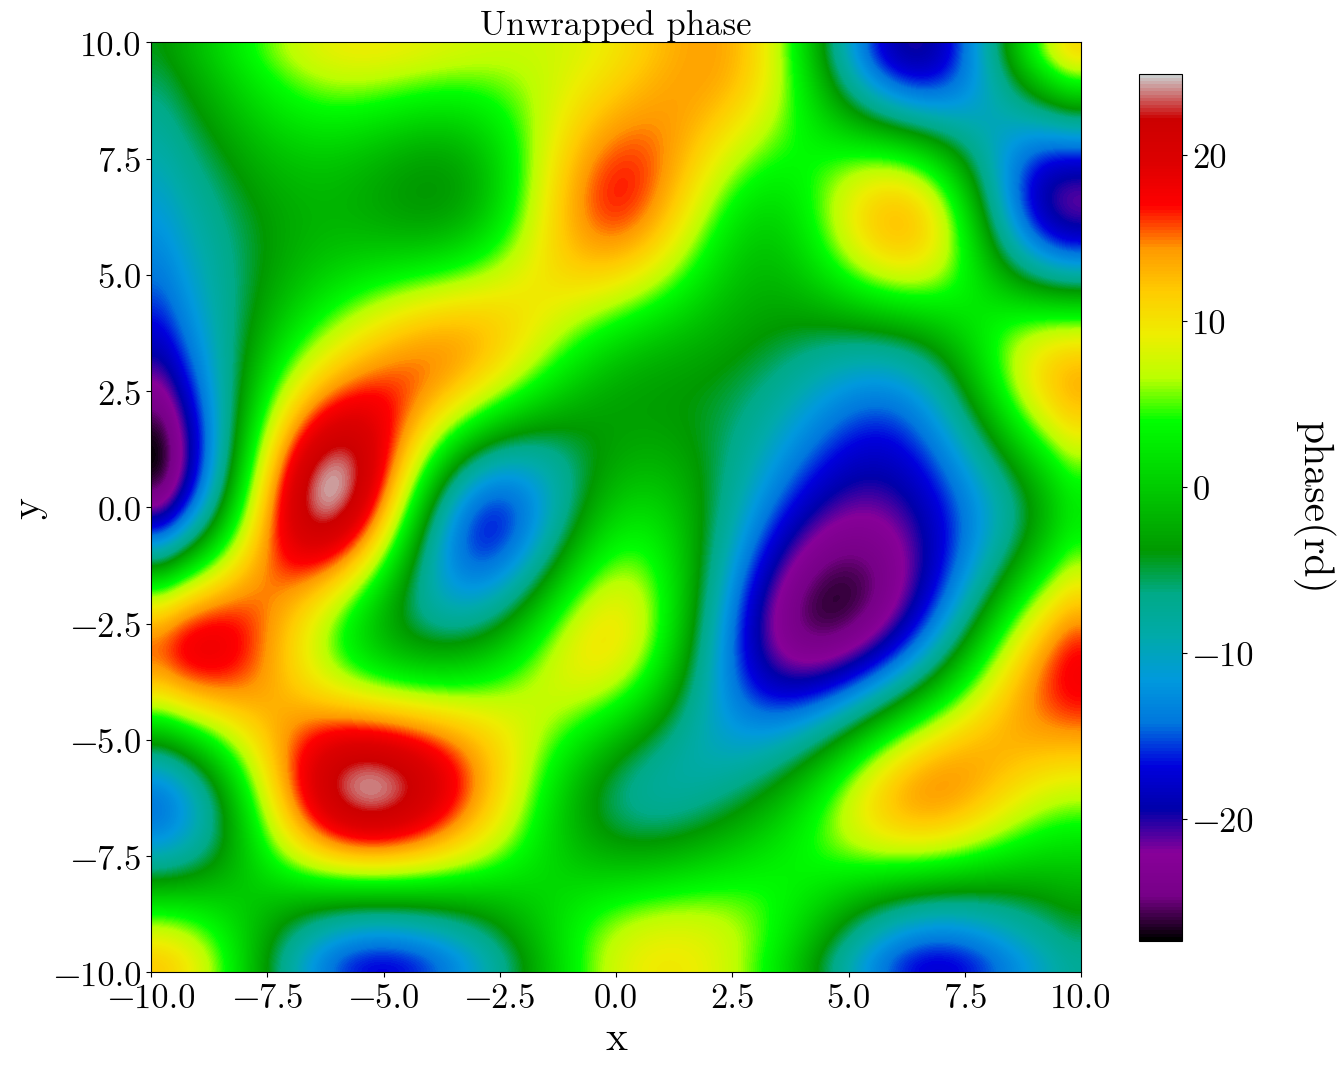

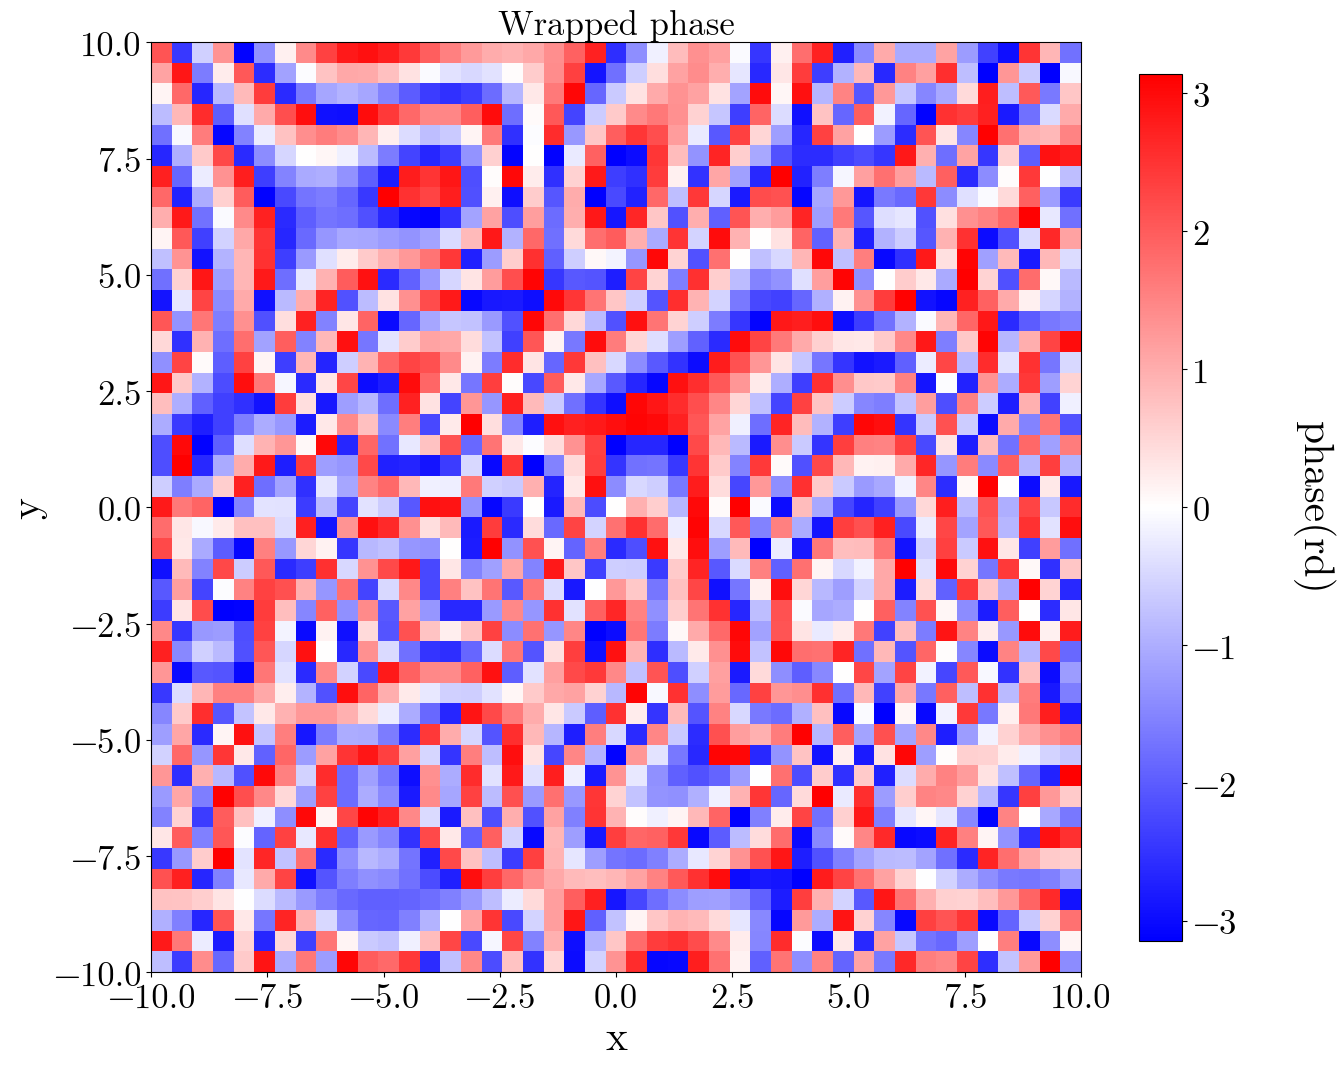

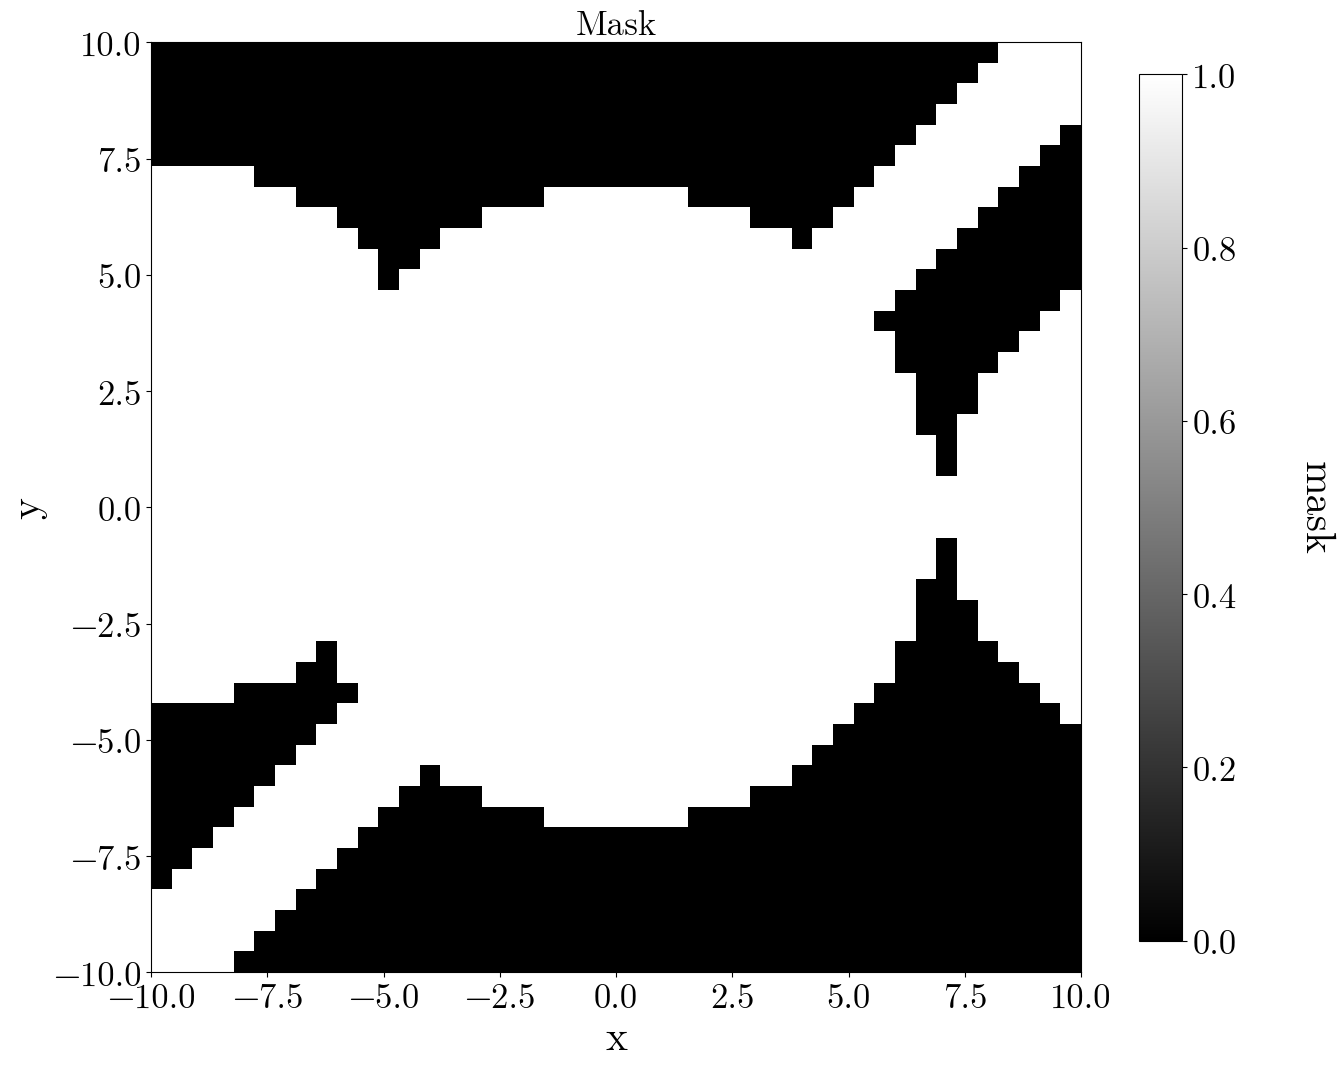

In [24]:
#ploting
plot_2D(phi,box,'phase(rd)','Unwrapped phase')
plot_2D(wrapped_phi,box,'phase(rd)','Wrapped phase',cmap='bwr',interpolate=False)
plot_2D(mask,box,'mask','Mask',cmap='gray',interpolate=False)

Change the value of $\sigma$ to minimize the error. There is no initial optimization of $\sigma$ in this version of the code.

In [25]:
sigma=15
data,grid=unpack_data(wrapped_phi,mask)
s=time.time()
w,grid,Nt,jac=LMA_2D(data,grid,mask,sigma=sigma)
e=time.time()
print('Solve time',e-s,'s on a 48-core 2-GHz server.')

Stage:                  3 
Steps:                 16 
Lambda:             0.025 
Error:         0.01209819552305504
Solve time 82.47893142700195 s on a 48-core 2-GHz server.


In [26]:
phi_RBFNN,d_phi_dx_RBFNN,d_phi_dy_RBFNN,d2_phi_dx2_RBFNN,d2_phi_dy2_RBFNN=repack_data(w,grid,wrapped_phi,Nt,sigma)

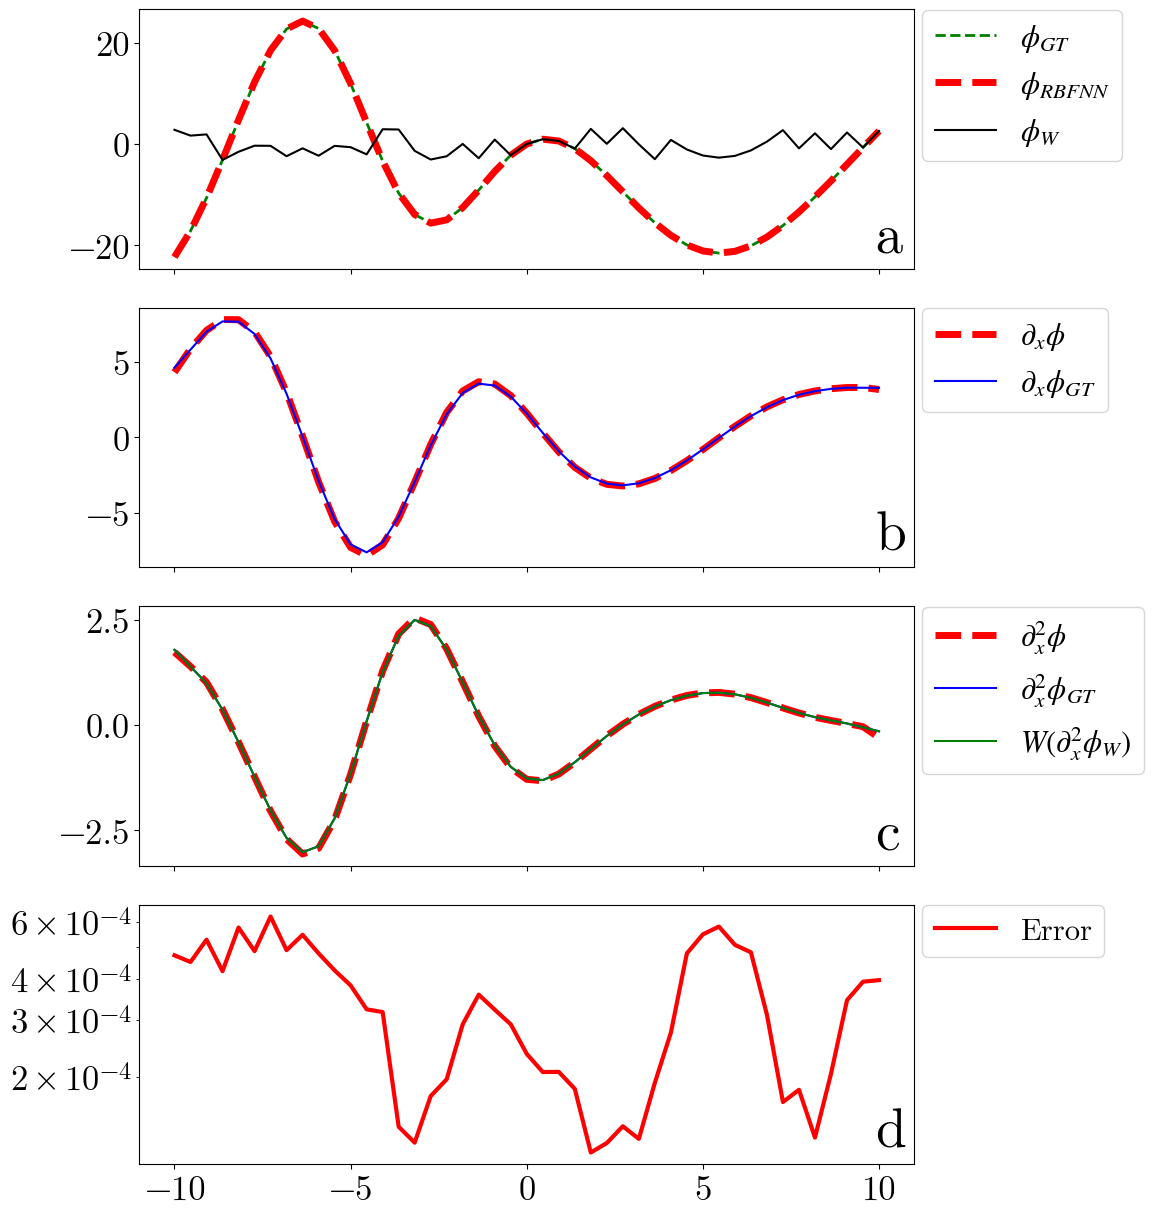

In [27]:
nx=len(phi[:,0])
mid_point=int(nx/2)
x=np.linspace(-xl,xl,nx)
#removed unknown phase bias from phi_RBFNN
phi_RBFNN-=np.average(phi_RBFNN[:,mid_point])*mask[:,mid_point]-np.average(phi[:,mid_point])
phi_RBFNN_slice=phi_RBFNN[:,mid_point]
phi_ref_slice=phi[:,mid_point]
wrapped_phi_slice=np.copy(phi_ref_slice)
wrapped_phi_slice=wrapped_phi[:,mid_point]
fig=plt.figure(figsize=(10,15))
ax=fig.add_subplot(4, 1, 1)
ax.label_outer()
WF(wrapped_phi_slice)
ax.plot(x,phi_ref_slice,label='$\phi_{GT}$',linewidth=2,linestyle='--',c='g')
ax.plot(x,phi_RBFNN_slice,label='$\phi_{RBFNN}$',linewidth=5,linestyle='--',c='r')
ax.plot(x,wrapped_phi_slice,label='$\phi_W$',c='black')
ax.text(.95,.025, 'a', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01, 1), ncol=1,loc='upper left', borderaxespad=.01,prop={"size":22})
ax=fig.add_subplot(4, 1, 2,sharex=ax)
ax.label_outer()
ax.plot(x,d_phi_dx_RBFNN[:,mid_point],label='$\partial_x\phi$',linewidth=5,linestyle='--',c='r')
ax.plot(x,DTC(phi[:,mid_point]),label='$\partial_x\phi_{GT}$',c='b')
ax.text(.95,.025, 'b', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01,1), ncol=1,loc='upper left', borderaxespad=.01,prop={"size":22})
ax=fig.add_subplot(4, 1, 3,sharex=ax)
ax.label_outer()
ax.plot(x,d2_phi_dx2_RBFNN[:,mid_point],label='$\partial_x^2\phi$',linewidth=5,linestyle='--',c='r')
ax.plot(x,D2T(phi[:,mid_point]),label='$\partial_x^2\phi_{GT}$',c='b')
ax.plot(x,WF(D2T(wrapped_phi[:,mid_point])),label='$W(\partial^2_x\phi_W)$',c='g')
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=.01,prop={"size":22},ncol=1)
ax.text(.95,.025, 'c', transform=ax.transAxes,fontsize=40,  va='bottom')
ax=fig.add_subplot(4, 1, 4,sharex=ax)
ax.plot(x,1e-4+abs(phi_ref_slice-phi_RBFNN_slice)/2./np.pi*mask[:,mid_point],label='Error',c='r',linewidth=3)
ax.text(.95,.025, 'd', transform=ax.transAxes,fontsize=40,  va='bottom')
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=.01,prop={"size":22},ncol=1)
ax.set_yscale('log')
plt.subplots_adjust(wspace=.04)
plt.subplots_adjust(hspace=.15)
plt.show()


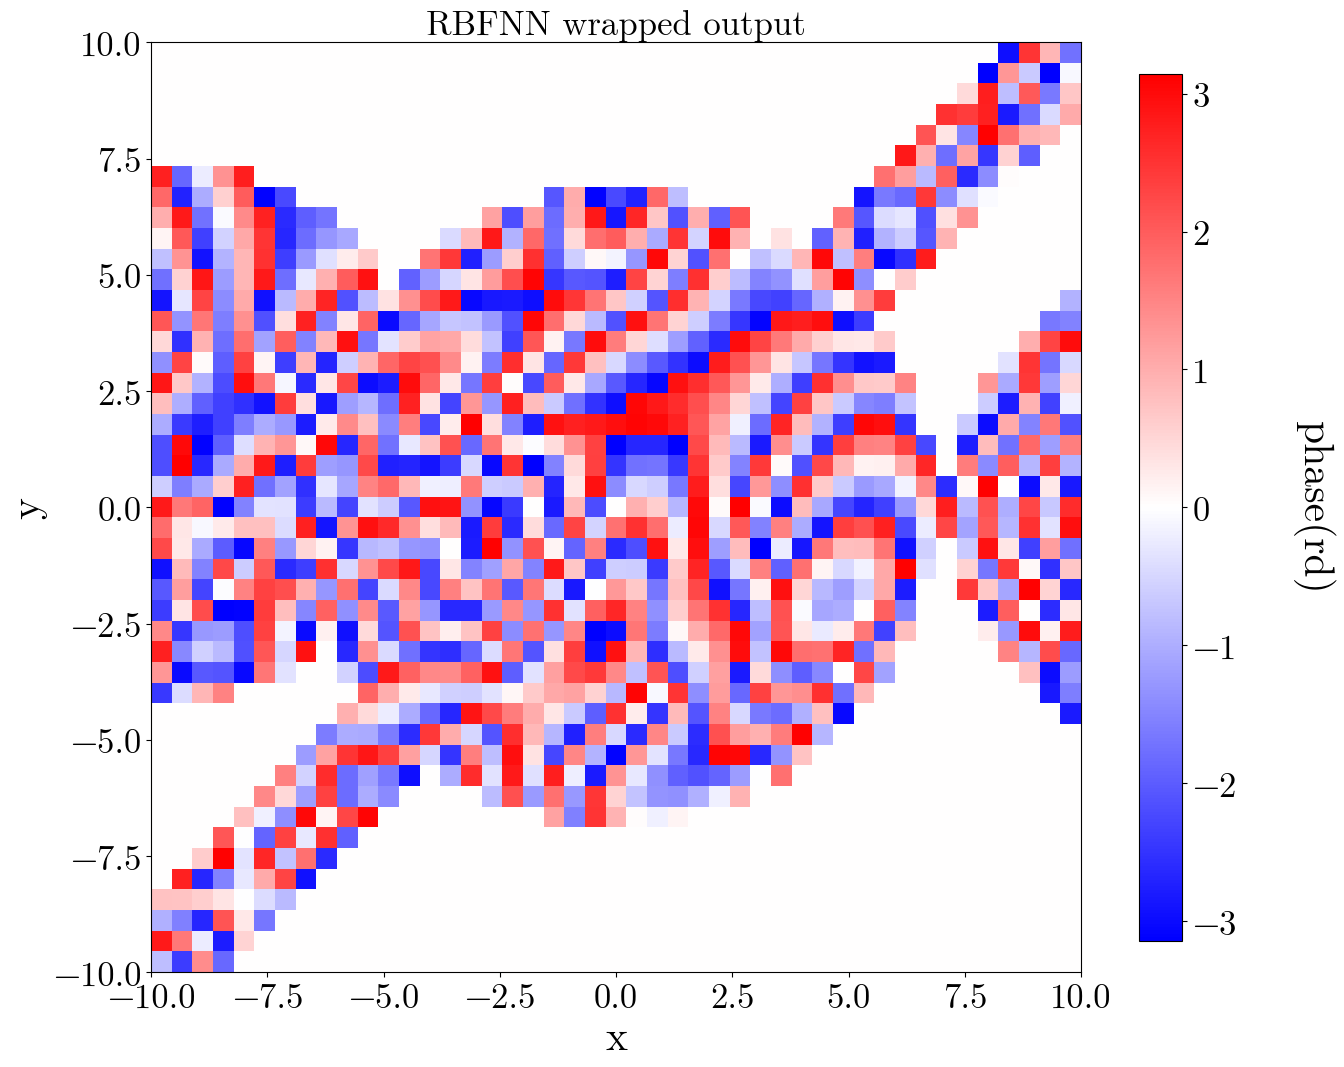

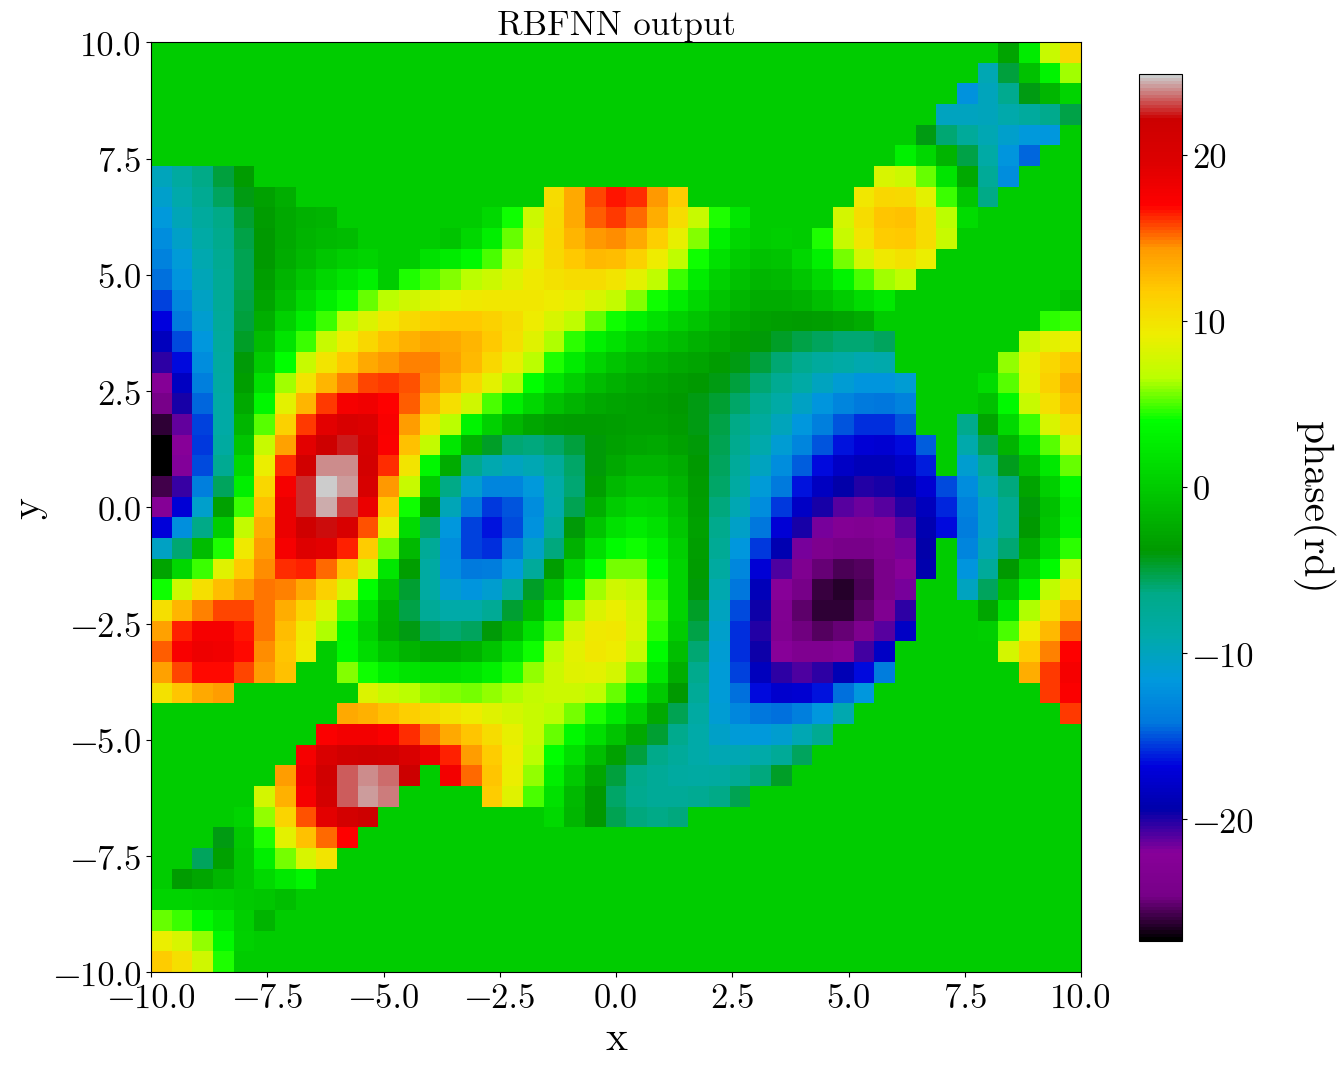

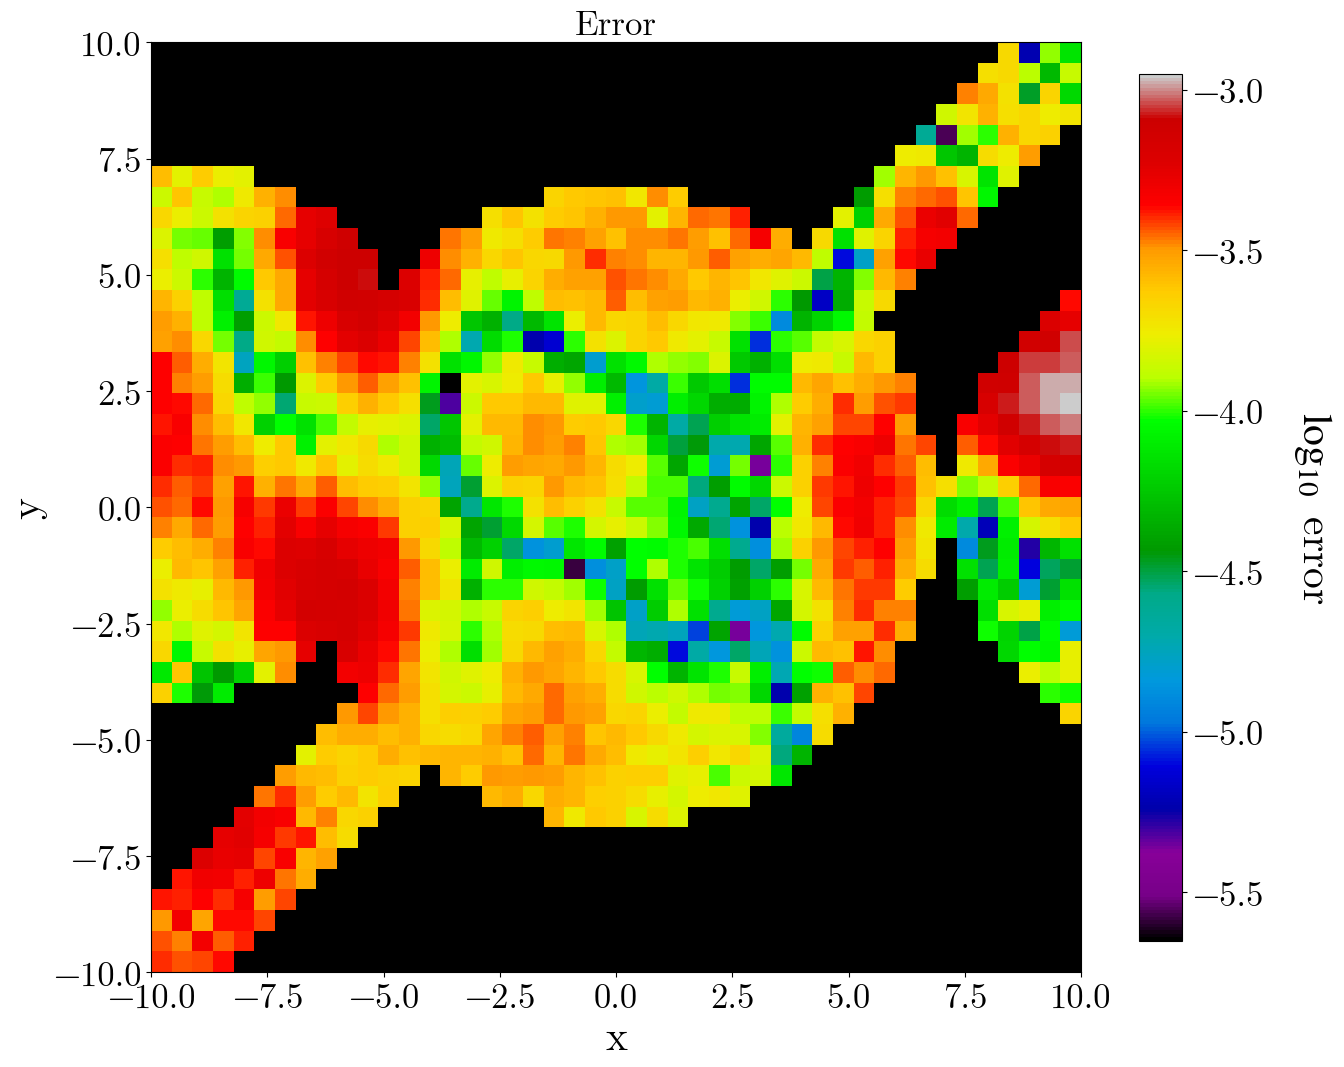

In [28]:
plot_2D(WF2D(phi_RBFNN),box,'phase(rd)','RBFNN wrapped output',cmap='bwr',interpolate=False)
plot_2D(phi_RBFNN,box,'phase(rd)','RBFNN output',interpolate=False)
error=np.log(np.abs(phi-phi_RBFNN)/2./np.pi)*mask/np.log(10)
plot_2D(error+np.amin(error)*(1-mask),box,'$\log_{10}$ error','Error',interpolate=False)
